### Project Structure

6. [**Model Training**](#sixth): Utilize machine learning algorithms to df a predictive model on the dfing data.
7. [**Model Evaluation**](#seventh): Evaluate the dfed model's performance using appropriate metrics and techniques.
8. [**Summary**](#eighth): Summary and future scope of the project
9. [**References**](#ninth): References, websites which I have used to complete this project

### Libraries

In [1]:
import os

# Ignore Warnings
import warnings

#data Manipulations
import pandas as pd
import numpy as np
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

%matplotlib inline

# Data Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Feature Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

# Models/Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier



# Metrics
import math
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from tqdm import tqdm

import joblib


warnings.filterwarnings('ignore')  # Disabling warning outputs

In [2]:
### Load data

save_directory = os.path.join('processed_data')

try:
    X_train = pd.read_csv(os.path.join(save_directory, 'X_train.csv'))
    X_test = pd.read_csv(os.path.join(save_directory, 'X_test.csv'))
    y_train = pd.read_csv(os.path.join(save_directory, 'y_train.csv')) #.squeeze() # .squeeze() to convert back to Series
    y_test = pd.read_csv(os.path.join(save_directory, 'y_test.csv'))# .squeeze()
    
    print(f"Loaded X_train shape: {X_train.shape}")
    print(f"Loaded y_train shape: {y_train.shape}")
    print("Data loaded successfully!")
except Exception as e:
    print(f"An error occurred while loading: {e}")

Loaded X_train shape: (1037340, 7)
Loaded y_train shape: (1037340, 1)
Data loaded successfully!


In [3]:
def map_genders(df):
    gender_mapping = {'M': 0, 'F': 1} # Or you could use {'M': 1, 'F': 0}

    # Apply the mapping directly to the 'gender' column in both training and testing sets
    df['gender'] = df['gender'].map(gender_mapping)
    return df

In [4]:
def fit_and_save_ohe(df, column='category', encoder_path='artifacts/category_ohe.pkl'):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe.fit(df[[column]])
    joblib.dump(ohe, encoder_path)
    ohe_features = ohe.transform(df[[column]])
    ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out([column]), index=df.index)
    return pd.concat([df.drop(columns=[column]), ohe_df], axis=1)


In [5]:
X_train = map_genders(X_train)
X_train = fit_and_save_ohe(X_train)
X_train.shape

(1037340, 20)

In [6]:
def load_and_transform_ohe(df, column='category', encoder_path='artifacts/category_ohe.pkl'):
    ohe = joblib.load(encoder_path)
    ohe_features = ohe.transform(df[[column]])
    ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out([column]), index=df.index)
    return pd.concat([df.drop(columns=[column]), ohe_df], axis=1)

In [7]:
X_test = map_genders(X_test)
X_test = load_and_transform_ohe(X_test)
X_test.shape

(259335, 20)

# <a id='sixth'></a> Model Training

### Model Evaluation with Grid Search and Cross-Validation

This code snippet demonstrates the process of evaluating multiple machine learning models using grid search and cross-validation. The goal is to find the best-performing model based on the R-squared score and root mean squared error (RMSE) on a test set.

#### Steps:
1. **Initialization**: 
   - An empty list `results` is initialized to store the evaluation results of each model.
   - Variables `best_model` and `accuracy` are initialized to track the best model and its accuracy score, respectively.

2. **Model Evaluation Loop**:
   - Iterate over each model in the `models` dictionary, which contains the names and instances of different machine learning models.
   - Create a pipeline with the current model.
   - Perform grid search with cross-validation using `GridSearchCV`. If hyperparameters are defined for the model in the `params` dictionary, grid search is performed with those hyperparameters; otherwise, default hyperparameters are used.
   - Fit the grid search to the training data.
   - Make predictions on the test set using the best model obtained from grid search.
   - Calculate the R-squared score and RMSE on the test set.
   - Update the `best_model` and `accuracy` variables if the current model performs better than the previous best model.
   - Append the evaluation results (model name, accuracy, classification report, and best parameters) to the `results` list.

3. **Results DataFrame**:
   - Create a DataFrame `results_df` from the `results` list containing the evaluation results for each model.

#### Benefits:
- **Automated Model Selection**: Grid search with cross-validation automates the process of hyperparameter tuning, making it easier to find the best-performing model.
- **Comprehensive Evaluation**: The evaluation results include both R-squared score and RMSE, providing insights into model performance.

#### Considerations:
- **Computational Complexity**: Grid search with cross-validation can be computationally expensive, especially for large datasets and complex models.
- **Overfitting**: Care should be taken to prevent overfitting by using appropriate regularization techniques and validation strategies.


In [8]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

## Random Forest classifier

In [9]:
param_grid = dict(
    n_estimators=stats.randint(10, 100),
    max_depth=stats.randint(10, 15),
    min_samples_split=stats.randint(1, 10),
    min_samples_leaf=stats.randint(1, 10),
)

rf_clf = RandomForestClassifier()
rf_cv = RandomizedSearchCV(
    rf_clf, param_grid, cv=3, n_iter=3, 
    scoring='roc_auc', n_jobs=-1, verbose=1
)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best Parameters: {best_params}")
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'max_depth': 14, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 39}
Train Result:
Accuracy Score: 99.77%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision  9.980280e-01     0.910092  0.997658  9.540599e-01  9.975190e-01
recall     9.996199e-01     0.660783  0.997658  8.302013e-01  9.976584e-01
f1-score   9.988233e-01     0.765654  0.997658  8.822385e-01  9.974736e-01
support    1.031335e+06  6005.000000  0.997658  1.037340e+06  1.037340e+06
_______________________________________________
Confusion Matrix: 
 [[1030943     392]
 [   2037    3968]]

Test Result:
Accuracy Score: 99.73%
_______________________________________________
CLASSIFICATION REPORT:
                       0            1  accuracy      macro avg   weighted avg
precision       0.997820     0.868519  0.997282       0.933169 

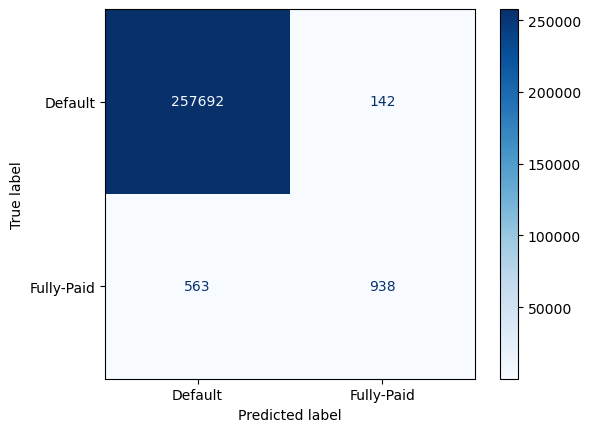

In [10]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

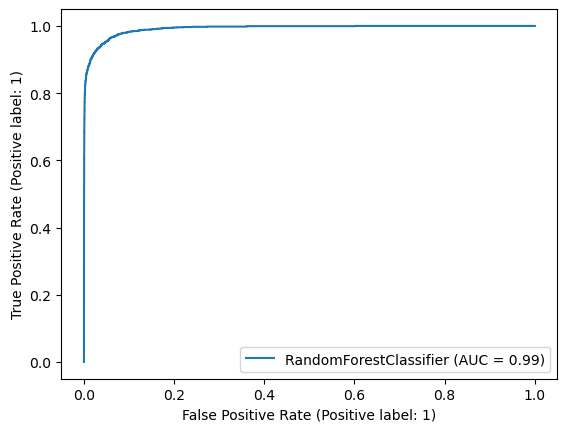

In [11]:
disp = RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)

### since we have highly imbalance dataset we should go with F1 score as evaluation metric
### we are still run few more algorithm and then we will use smote and then re-run same algorithms

## Logistic regression - with L1 and L2

In [12]:
param_grid = dict(
    penalty = ['l1', 'l2'],
    C = [0.001, 0.01, 0.1, 1, 10],
    solver = ['liblinear', 'saga']
)

lr_clf = LogisticRegression()
lr_cv = RandomizedSearchCV(
    lr_clf, param_grid, cv=3, n_iter=3, 
    scoring='roc_auc', n_jobs=-1, verbose=1
)
lr_cv.fit(X_train, y_train)
best_params = lr_cv.best_params_
print(f"Best Parameters: {best_params}")
lr_clf = LogisticRegression(**best_params)
lr_clf.fit(X_train, y_train)

y_train_pred = lr_clf.predict(X_train)
y_test_pred = lr_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.001}
Train Result:
Accuracy Score: 99.37%
_______________________________________________
CLASSIFICATION REPORT:
                      0       1  accuracy     macro avg  weighted avg
precision  9.942080e-01     0.0  0.993668  4.971040e-01  9.884527e-01
recall     9.994541e-01     0.0  0.993668  4.997271e-01  9.936684e-01
f1-score   9.968242e-01     0.0  0.993668  4.984121e-01  9.910537e-01
support    1.031335e+06  6005.0  0.993668  1.037340e+06  1.037340e+06
_______________________________________________
Confusion Matrix: 
 [[1030772     563]
 [   6005       0]]

Test Result:
Accuracy Score: 99.38%
_______________________________________________
CLASSIFICATION REPORT:
                       0       1  accuracy      macro avg   weighted avg
precision       0.994209     0.0  0.993757       0.497105       0.988455
recall          0.999542     0.0  0.993757       0.4

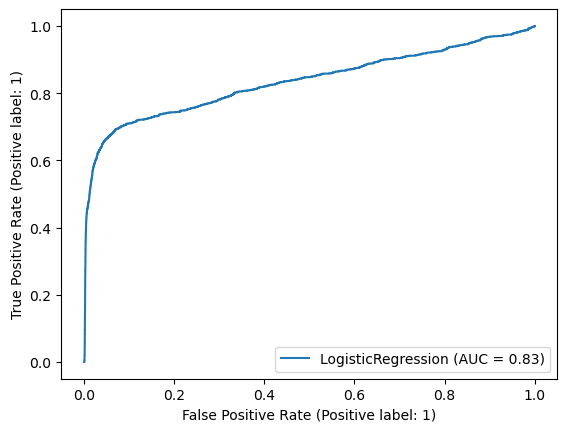

In [13]:
disp = RocCurveDisplay.from_estimator(lr_clf, X_test, y_test)

## XB Boost

In [14]:
param_grid = dict(
    n_estimators=stats.randint(10, 50),
    max_depth=stats.randint(1, 5),
    learning_rate=stats.uniform(0, 1)
)

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_cv = RandomizedSearchCV(
    xgb_clf, param_grid, cv=3, n_iter=3, 
    scoring='roc_auc', n_jobs=-1, verbose=1
)
xgb_cv.fit(X_train, y_train)

best_params = xgb_cv.best_params_
# best_params['tree_method'] = 'gpu_hist'
# best_params = {'n_estimators': 50, 'tree_method': 'gpu_hist'}
print(f"Best Parameters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'learning_rate': 0.811227683811121, 'max_depth': 4, 'n_estimators': 24}
Train Result:
Accuracy Score: 99.69%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision  9.976843e-01     0.821323  0.996936  9.095037e-01  9.966634e-01
recall     9.992379e-01     0.601665  0.996936  8.004516e-01  9.969364e-01
f1-score   9.984605e-01     0.694541  0.996936  8.465005e-01  9.967011e-01
support    1.031335e+06  6005.000000  0.996936  1.037340e+06  1.037340e+06
_______________________________________________
Confusion Matrix: 
 [[1030549     786]
 [   2392    3613]]

Test Result:
Accuracy Score: 99.69%
_______________________________________________
CLASSIFICATION REPORT:
                       0            1  accuracy      macro avg   weighted avg
precision       0.997626     0.829132  0.996931       0.913379       0.9966

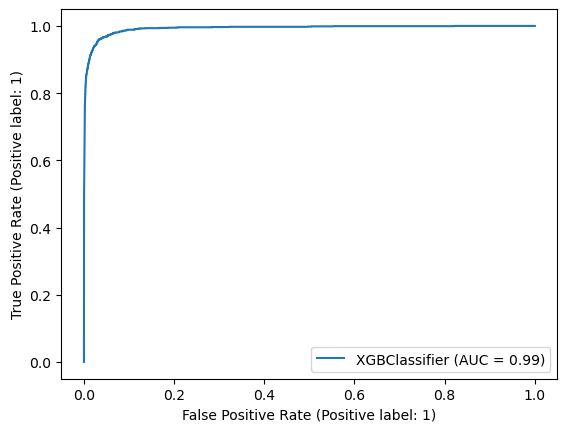

In [15]:
disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

## Light GBM

In [16]:
print("\n--- LightGBM Model Training ---")

# Define parameter distributions for LightGBM
lgbm_param_grid = dict(
    n_estimators=stats.randint(10, 50),          # Number of boosting rounds
    learning_rate=stats.loguniform(0.01, 0.2),   # Step size shrinkage
    num_leaves=stats.randint(20, 60),            # Max tree leaves for base learners
    max_depth=stats.randint(5, 15),              # Max tree depth
    min_child_samples=stats.randint(1, 10),      # Minimum data in a child
    subsample=stats.uniform(0.7, 0.3),           # Subsample ratio of the training instance (bagging_fraction)
    colsample_bytree=stats.uniform(0.7, 0.3),    # Subsample ratio of columns (feature_fraction)
    reg_alpha=stats.loguniform(1e-3, 10.0),      # L1 regularization
    reg_lambda=stats.loguniform(1e-3, 10.0),     # L2 regularization
)

# Initialize LightGBM Classifier
lgbm_clf = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1) # verbose=-1 to suppress verbose output during training

# Initialize RandomizedSearchCV
lgbm_cv = RandomizedSearchCV(
    lgbm_clf,
    lgbm_param_grid,
    cv=3,                 # Number of cross-validation folds
    n_iter=3,             # Number of parameter settings that are sampled (adjust as needed for thoroughness)
    scoring='roc_auc',    # Metric to optimize
    n_jobs=-1,            # Use all available CPU cores
    verbose=1,            # Controls the verbosity: 0 = silent, 1 = progress bar, 2 = verbose
    random_state=42       # For reproducibility of sampling
)

# Fit RandomizedSearchCV to the training data
lgbm_cv.fit(X_train, y_train)

# Get the best parameters
best_params_lgbm = lgbm_cv.best_params_
print(f"\nBest LightGBM Parameters: {best_params_lgbm}")

# Train the final LightGBM model with the best parameters
lgbm_clf = lgb.LGBMClassifier(**best_params_lgbm, random_state=42, n_jobs=-1, verbose=-1)
lgbm_clf.fit(X_train, y_train)

# Make predictions
y_train_pred_lgbm = lgbm_clf.predict(X_train)
y_test_pred_lgbm = lgbm_clf.predict(X_test)

# Print scores
print_score(y_train, y_train_pred_lgbm, train=True)
print_score(y_test, y_test_pred_lgbm, train=False)



--- LightGBM Model Training ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best LightGBM Parameters: {'colsample_bytree': 0.7428600453765822, 'learning_rate': 0.07027897634919636, 'max_depth': 9, 'min_child_samples': 2, 'n_estimators': 33, 'num_leaves': 49, 'reg_alpha': 0.0070689749506246055, 'reg_lambda': 0.005337032762603957, 'subsample': 0.7550213529560301}
Train Result:
Accuracy Score: 99.70%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision  9.980345e-01     0.791401  0.997034  8.947179e-01  9.968383e-01
recall     9.989838e-01     0.662115  0.997034  8.305494e-01  9.970338e-01
f1-score   9.985090e-01     0.721008  0.997034  8.597586e-01  9.969025e-01
support    1.031335e+06  6005.000000  0.997034  1.037340e+06  1.037340e+06
_______________________________________________
Confusion Matrix: 
 [[1030287    1048]
 [   2029    3976]]

Test Result:
Accuracy Score:

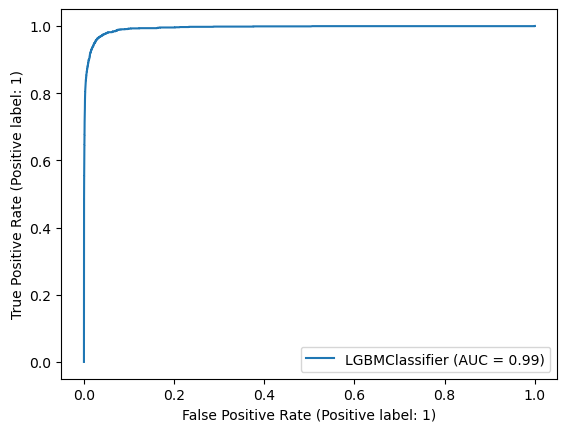

In [17]:
disp = RocCurveDisplay.from_estimator(lgbm_clf, X_test, y_test)

## Catboost 

In [18]:
print("\n--- CatBoost Model Training ---")

# Define parameter distributions for CatBoost
catboost_param_grid = dict(
    iterations=stats.randint(10, 100),           # Number of boosting iterations (like n_estimators)
    learning_rate=stats.loguniform(0.01, 0.2),   # Step size shrinkage
    depth=stats.randint(1, 10),                  # Depth of the tree (like max_depth)
    l2_leaf_reg=stats.loguniform(1e-3, 10.0),    # L2 regularization
    random_strength=stats.loguniform(0.1, 10.0), # Randomization strength (for splits)
    border_count=stats.randint(1, 8),          # Number of splits for numerical features
    bagging_temperature=stats.uniform(0.0, 1.0), # Controls intensity of Bayesian bagging
)

# Initialize CatBoost Classifier
cat_clf = CatBoostClassifier(
    random_state=42,
    verbose=0,          # Suppress verbose output during training
    eval_metric='AUC',  # Metric to monitor during training
    # For imbalanced data, consider scale_pos_weight or auto_class_weights
    # scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum()
)

# Initialize RandomizedSearchCV
cat_cv = RandomizedSearchCV(
    cat_clf,
    catboost_param_grid,
    cv=3,                 # Number of cross-validation folds
    n_iter=3,             # Number of parameter settings that are sampled (adjust as needed)
    scoring='roc_auc',    # Metric to optimize
    n_jobs=-1,            # Use all available CPU cores
    verbose=1,            # Controls the verbosity
    random_state=42       # For reproducibility of sampling
)

# Fit RandomizedSearchCV to the training data
cat_cv.fit(X_train, y_train)

# Get the best parameters
best_params_cat = cat_cv.best_params_
print(f"\nBest CatBoost Parameters: {best_params_cat}")

# Train the final CatBoost model with the best parameters
cat_clf = CatBoostClassifier(**best_params_cat, random_state=42, verbose=0, eval_metric='AUC')
cat_clf.fit(X_train, y_train)

# Make predictions
y_train_pred_cat = cat_clf.predict(X_train)
y_test_pred_cat = cat_clf.predict(X_test)

# Print scores
print_score(y_train, y_train_pred_cat, train=True)
print_score(y_test, y_test_pred_cat, train=False)


--- CatBoost Model Training ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best CatBoost Parameters: {'bagging_temperature': 0.3745401188473625, 'border_count': 5, 'depth': 8, 'iterations': 70, 'l2_leaf_reg': 0.24400607090817547, 'learning_rate': 0.03802259770124277, 'random_strength': 0.15847101210439093}
Train Result:
Accuracy Score: 99.45%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision  9.945131e-01     0.963303  0.994503  9.789079e-01  9.943324e-01
recall     9.999884e-01     0.052456  0.994503  5.262223e-01  9.945032e-01
f1-score   9.972432e-01     0.099495  0.994503  5.483689e-01  9.920463e-01
support    1.031335e+06  6005.000000  0.994503  1.037340e+06  1.037340e+06
_______________________________________________
Confusion Matrix: 
 [[1031323      12]
 [   5690     315]]

Test Result:
Accuracy Score: 99.45%
_______________________________________________

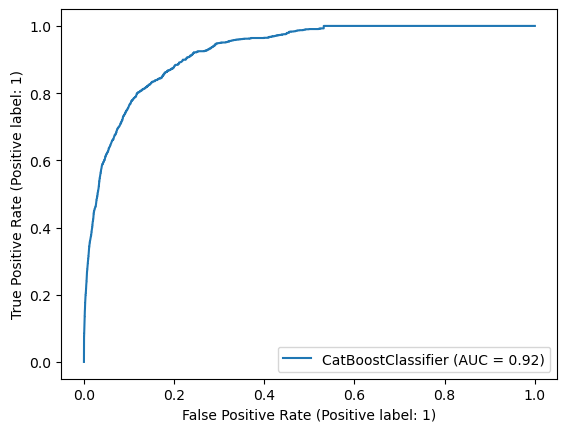

In [19]:
disp = RocCurveDisplay.from_estimator(cat_clf, X_test, y_test)

# <a id='seventh'></a> Model Evaluation

### Model Evaluation on Test Set
#### Because of the imbalance data, it shows high number of False Positive (confustion metrix for above models)

This code snippet demonstrates how to evaluate the best model selected during the grid search process on the test set. The evaluation metric used here is the 'Accuracy Score', which measures how many correct predictions happened from all predictions.
Thou its not the best one. personally I would go for f1 score.

#### Steps:
1. **Prediction**: 
   - Make predictions on the test set using the best model (`best_model.predict(X_test)`). In this case, we are going with RandomForest.

2. **Accuracy Calculation**:
   - Calculate the Accuracy score using the predicted values and true target values.
   - Accuracy score measures the goodness-of-fit of the model

#### Benefits:
- **Model Generalization Assessment**: The accuracy score on the test set provides insights into how well the model generalizes to unseen data.
- **Performance Communication**: Communicating the accuracy score allows stakeholders to understand the effectiveness of the predictive model.

#### Considerations:
- **Interpretation**: A higher accuracy score indicates better model performance, with values closer to 1 indicating a better fit. However, accuracy should be interpreted in the context of the problem domain and compared to alternative models.

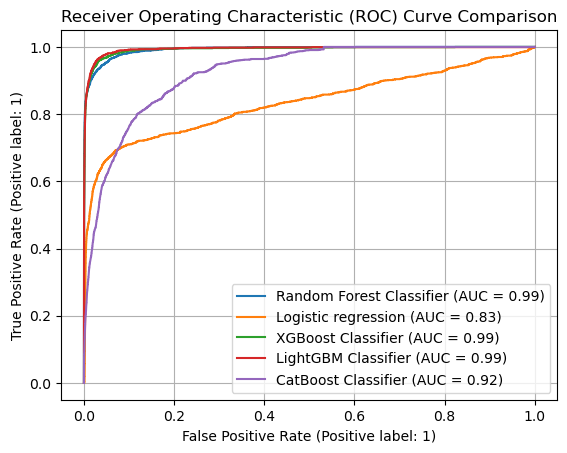


ROC AUC curves plotted successfully using RocCurveDisplay.from_estimator.


In [20]:
models_to_plot = [
    (rf_clf, 'Random Forest Classifier'),
    (lr_clf, 'Logistic regression'),
    (xgb_clf, 'XGBoost Classifier'),
    (lgbm_clf, 'LightGBM Classifier'),
    (cat_clf, 'CatBoost Classifier')
]

# Check if the models_to_plot list is empty
if not models_to_plot:
    print("Error: 'models_to_plot' list is empty. Please add your trained model objects and their names.")
else:
    # Initialize the plot with the first model
    # RocCurveDisplay.from_estimator returns a display object.
    # We pass 'name' here for the legend label.
    first_model, first_model_name = models_to_plot[0]
    disp = RocCurveDisplay.from_estimator(first_model, X_test, y_test, name=first_model_name)

    # Loop through the rest of the models and plot their ROC curves on the same axes.
    # We use 'ax=disp.ax_' to plot on the existing axes.
    for model, name in models_to_plot[1:]:
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=disp.ax_, name=name)

    # Add a title to the plot
    plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
    
    # Add a grid for better readability (optional)
    plt.grid(True)
    
    # Display the plot
    plt.show()

    print("\nROC AUC curves plotted successfully using RocCurveDisplay.from_estimator.")

# <a id='eighth'></a> Summary

This This predictive model can be strategically integrated into the Lending Club's operations to enhance decision-making and mitigate risks. Potential applications include:

>`Real-time Transaction Monitoring`
>
>`Customer Behavioral Anomaly Detection`
>
>`Merchant Fraud Prevention`
>
>`Internal Fraud Detection`

#### Continuous improvement and adaptation
Fraud detection can further enhance its operational efficiency, mitigate financial risks, and make more informed decisions, ultimately benefiting both the platform and its users. Continuous improvement and adaptation are key to maximizing the long-term value of this data science initiative.

#### Future scope:
1. **Balance data**: 
   - Target variable(Loan status is highly imbalance)
   - Use SMOTE or
   - Use stratified K fold cross validations for training

2. **Scaler**:
   - So far we have not used any scaler but standard scaler will give better accuracy
   - We can use One hot encoding for categorical features

3. **Dimensionaly reduction**
   - We can implement dimensionaly reduction using PCA for faster convergence of model

4. **Correlations**
   - Features are corelated
   - we can apply L2(ridge) regression for feature selection

5. **More models**
   - we can apply more models and they we can compare those models

6. **Data types**
   - Most of the features data types are Float64, Int64, Int32
   - Categorical features, we can apply Int8
   - Few numerical features, we can apply Float8 such as 'Interest Rate'

7. **Optuna**
   - Instead of grid search, we can use optuna for hyperparameter tuning

8. **SHAP**
   - Implement SHAP for getting more related features thru shap_values

9. **Data drift/ concept drift**
    - Implement stratagies for data drift and/or concept drift

10. **F1 Score**
    - F1 score will be the correct metric to evaluate this problem.
    - I have use accuracy for time being but in version 2, I will implement f1 score

# <a id='ninth'></a> References

[Fraud detections Data](https://www.kaggle.com/code/ambarishdeb/credit-card-fraud-prediction-eda-ml-evaluation/input) - Credit Card Fraud Prediction EDA ML Evaluation

[Google](https://www.google.com) - To get domain knowledge regarding features

[Keggle Notebook](https://www.kaggle.com/code/ambarishdeb/credit-card-fraud-prediction-eda-ml-evaluation/notebook) - Used for some visualization assistance

[HVPlots](https://hvplot.holoviz.org/getting_started/installation.html) - I used hvplots for dynamic graphs